In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from model_evaluate import evaluate_model

In [2]:
# Step 1: Load Time Series Data
train_data = pd.read_csv("train_timeseries.csv")
test_data = pd.read_csv("test_timeseries.csv")

feature_columns = [column_name for column_name in train_data.columns if column_name not in ['Time', 'PV_production', 'Wind_production']]
target_columns = ['PV_production', 'Wind_production']

print(f"Using {len(feature_columns)} features for training.")

X_train = train_data[feature_columns].values
y_train = train_data[target_columns].values
X_test = test_data[feature_columns].values
y_test = test_data[target_columns].values

Using 67 features for training.


In [3]:
# Step 2: Scale Data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [4]:
# Step 3: Create Sequence Windows
def create_sequences(X, y, window_size):
    Xs, ys = [], []
    for i in range(window_size, len(X)):
        Xs.append(X[i - window_size:i])
        ys.append(y[i])
    return np.array(Xs), np.array(ys)

In [5]:
# Step 4: Model Builder
def build_lstm_model(act_fn='tanh', rec_act_fn='sigmoid', dense_act='relu', input_shape=None):
    model = Sequential()
    model.add(LSTM(
        units=64,
        activation=act_fn,
        recurrent_activation=rec_act_fn,
        input_shape=input_shape
    ))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=dense_act))
    model.add(Dense(2, activation='linear'))  # two outputs: PV & Wind
    model.compile(optimizer='adam', loss='mse')
    return model

In [6]:
# Step 5: Define Configurations to Explore
window_sizes = [12, 24, 48]
activation_combos = [
    ('tanh', 'sigmoid', 'relu'),
    ('relu', 'sigmoid', 'relu'),
    ('selu', 'tanh', 'relu'),
    ('tanh', 'hard_sigmoid', 'elu')
]

results_summary = []
tf.keras.utils.set_random_seed(42)

In [7]:
# Step 6: Train and Evaluate All Combinations
for window_size in window_sizes:
    X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, window_size)
    X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, window_size)

    print(f"\n{'~'*90}")
    print(f"Training the model with the window size: {window_size}")
    print(f"{'~'*90}")

    for act, rec_act, dense_act in activation_combos:
        print(f"→ LSTM({act}, {rec_act}) + Dense({dense_act}) [window={window_size}]")

        model = build_lstm_model(act, rec_act, dense_act, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]))
        early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, min_delta=0.001)

        model.fit(
            X_train_seq, y_train_seq,
            epochs=20,
            batch_size=64,
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=0
        )

        y_pred_scaled = model.predict(X_test_seq, verbose=0)
        y_pred = scaler_y.inverse_transform(y_pred_scaled)
        y_true = scaler_y.inverse_transform(y_test_seq)

        r2_pv = r2_score(y_true[:, 0], y_pred[:, 0])
        r2_wind = r2_score(y_true[:, 1], y_pred[:, 1])
        mae_pv = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
        mae_wind = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
        rmse_pv = np.sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
        rmse_wind = np.sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

        results_summary.append({
            'window': window_size,
            'act': act,
            'rec_act': rec_act,
            'dense_act': dense_act,
            'r2_pv': r2_pv,
            'r2_wind': r2_wind,
            'r2_sum': r2_pv + r2_wind,
            'mae_pv': mae_pv,
            'mae_wind': mae_wind,
            'rmse_pv': rmse_pv,
            'rmse_wind': rmse_wind,
            'model': model
        })


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training the model with the window size: 12
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
→ LSTM(tanh, sigmoid) + Dense(relu) [window=12]


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


→ LSTM(relu, sigmoid) + Dense(relu) [window=12]


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


→ LSTM(selu, tanh) + Dense(relu) [window=12]


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


→ LSTM(tanh, hard_sigmoid) + Dense(elu) [window=12]


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training the model with the window size: 24
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
→ LSTM(tanh, sigmoid) + Dense(relu) [window=24]


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


→ LSTM(relu, sigmoid) + Dense(relu) [window=24]


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


→ LSTM(selu, tanh) + Dense(relu) [window=24]


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


→ LSTM(tanh, hard_sigmoid) + Dense(elu) [window=24]


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Training the model with the window size: 48
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
→ LSTM(tanh, sigmoid) + Dense(relu) [window=48]


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


→ LSTM(relu, sigmoid) + Dense(relu) [window=48]


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


→ LSTM(selu, tanh) + Dense(relu) [window=48]


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


→ LSTM(tanh, hard_sigmoid) + Dense(elu) [window=48]


c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Step 7: Identifying Best Model
best_result = max(results_summary, key=lambda x: x['r2_sum'])
best_model = best_result['model']
window_best = best_result['window']

print("\n" + "="*90)
print("Best Model Configuration:")
print(f"Window Size: {window_best}")
print(f"LSTM Activations: {best_result['act']} / {best_result['rec_act']} | Dense: {best_result['dense_act']}")
print(f"R² (PV): {best_result['r2_pv']:.3f}, R² (Wind): {best_result['r2_wind']:.3f}")
print("~"*90)


Best Model Configuration:
Window Size: 48
LSTM Activations: tanh / hard_sigmoid | Dense: elu
R² (PV): 0.980, R² (Wind): 0.962
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


363/363 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
--- LSTM (window=48, tanh, hard_sigmoid, elu) - PV Production ---
MAE: 506.769
MSE: 356907.760
RMSE: 597.418
R²: 0.980
Adjusted R²: 0.980
Explained Variance: 0.982
Sample Size: 11616
Visualization Sample: 5,000 points


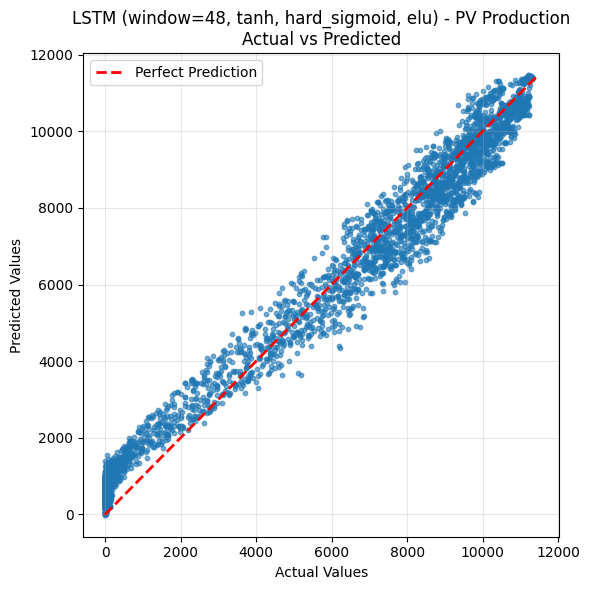

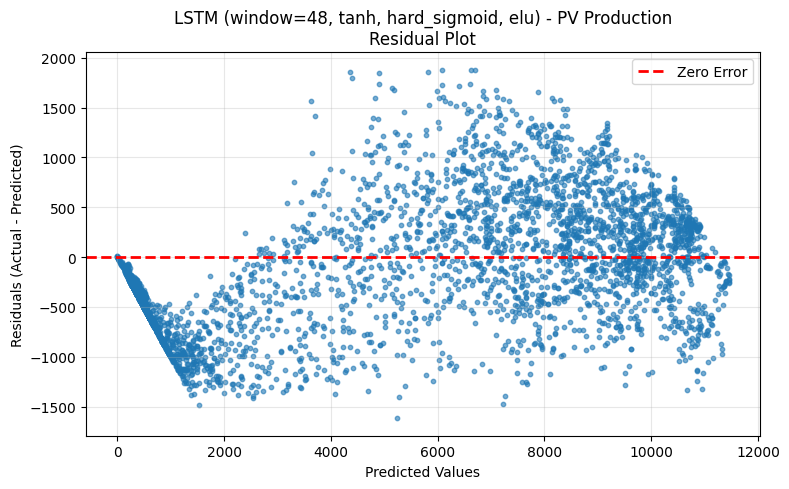

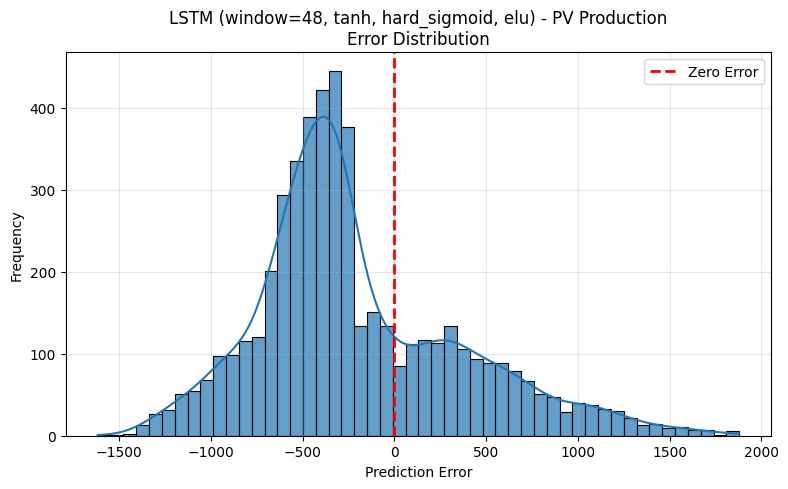

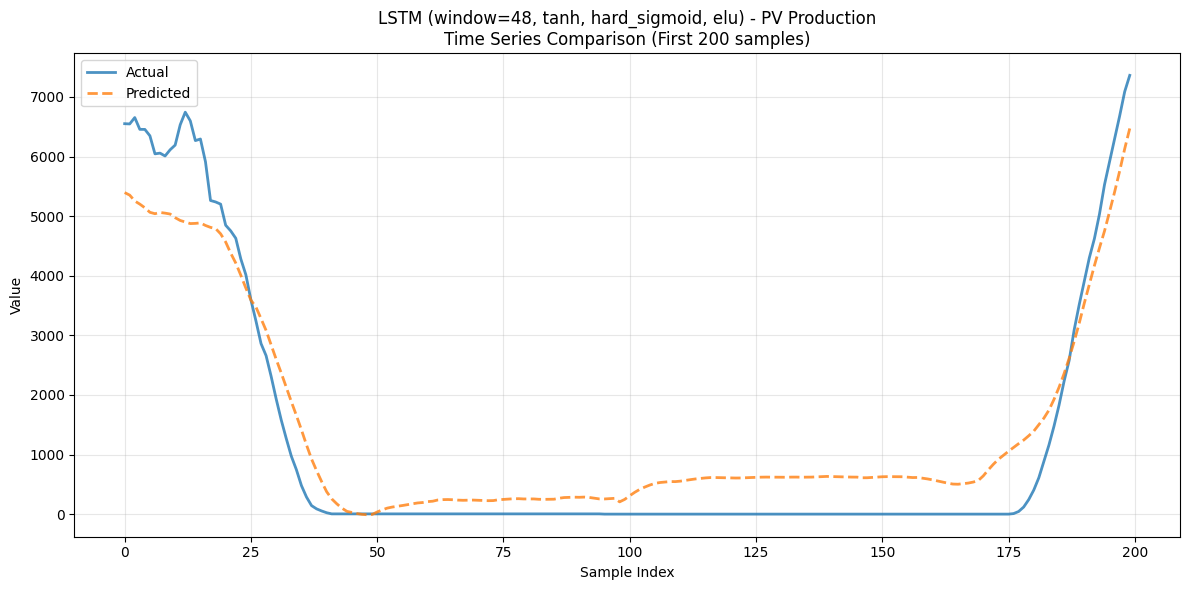

--- LSTM (window=48, tanh, hard_sigmoid, elu) - Wind Production ---
MAE: 188.229
MSE: 53027.787
RMSE: 230.278
R²: 0.962
Adjusted R²: 0.962
Explained Variance: 0.963
Sample Size: 11616
Visualization Sample: 5,000 points


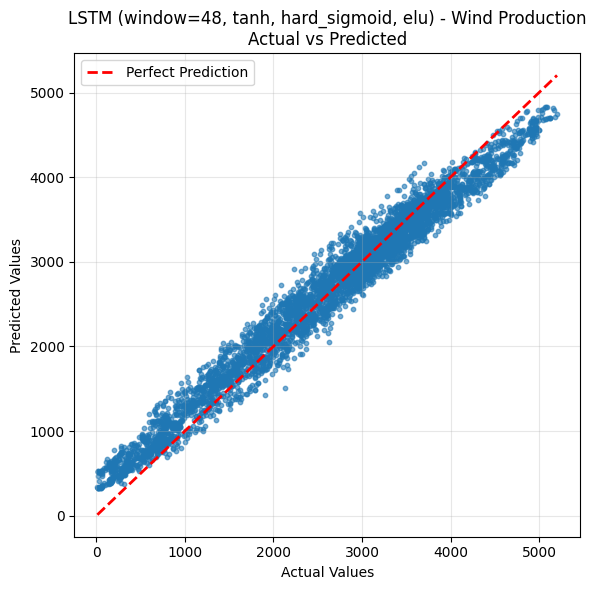

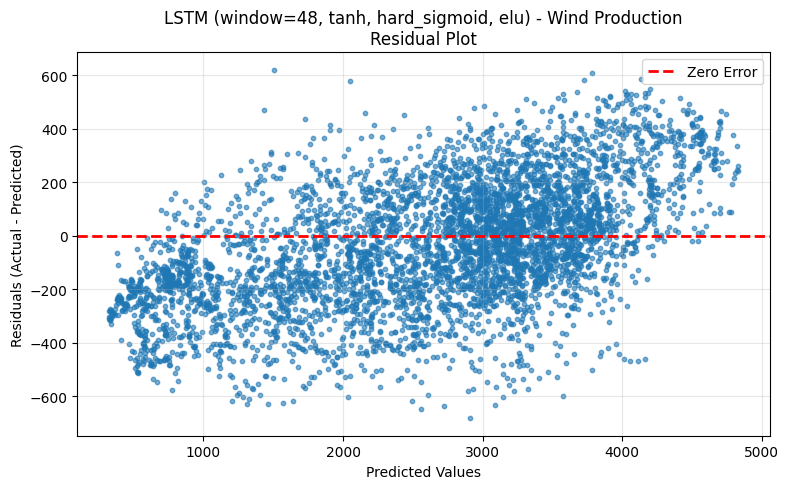

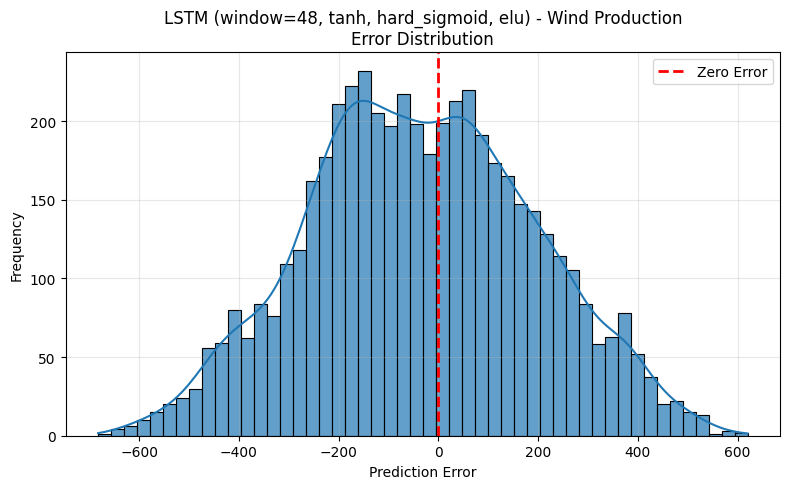

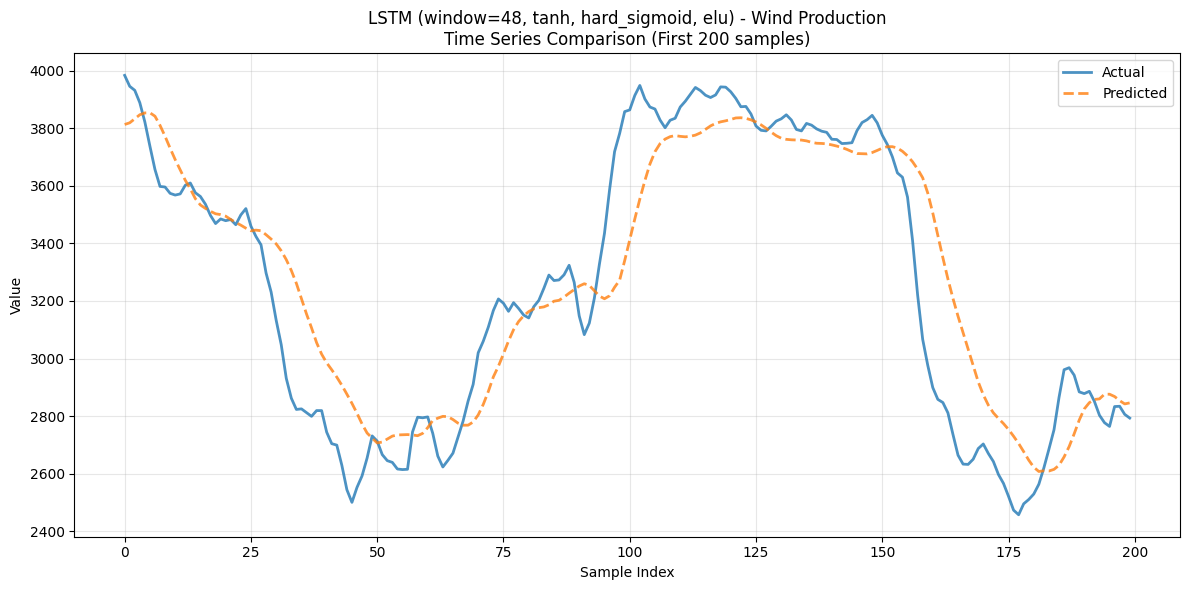

{'mae': np.float64(188.2293540045578),
 'mse': np.float64(53027.78746766864),
 'rmse': np.float64(230.27763127943766),
 'r2': 0.9623638673492054,
 'adj_r2': 0.962145507383185,
 'explained_variance': 0.9633814876774607}

In [9]:
# Step 8: Detailed Evaluation for Best Model (with plots)
X_train_seq_best, y_train_seq_best = create_sequences(X_train_scaled, y_train_scaled, window_best)
X_test_seq_best, y_test_seq_best = create_sequences(X_test_scaled, y_test_scaled, window_best)

y_pred_scaled_best = best_model.predict(X_test_seq_best)
y_pred_best = scaler_y.inverse_transform(y_pred_scaled_best)
y_true_best = scaler_y.inverse_transform(y_test_seq_best)

evaluate_model(
    y_true=y_true_best[:, 0],
    y_pred=y_pred_best[:, 0],
    model_name=f"LSTM (window={window_best}, {best_result['act']}, {best_result['rec_act']}, {best_result['dense_act']})",
    target_name="PV Production",
    feature_names=feature_columns
)

evaluate_model(
    y_true=y_true_best[:, 1],
    y_pred=y_pred_best[:, 1],
    model_name=f"LSTM (window={window_best}, {best_result['act']}, {best_result['rec_act']}, {best_result['dense_act']})",
    target_name="Wind Production",
    feature_names=feature_columns
)

In [10]:
# Step 9: Print Final Summary Table
print("\n~~~~~~~~~~~~~~~~ SUMMARY OF ALL TESTED CONFIGURATIONS ~~~~~~~~~~~~~~~~")
for res in results_summary:
    print(f"[window={res['window']:>2}] LSTM({res['act']},{res['rec_act']}), Dense({res['dense_act']}) → "
          f"R²_PV={res['r2_pv']:.3f}, R²_Wind={res['r2_wind']:.3f}, R²_Sum={res['r2_sum']:.3f}")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


~~~~~~~~~~~~~~~~ SUMMARY OF ALL TESTED CONFIGURATIONS ~~~~~~~~~~~~~~~~
[window=12] LSTM(tanh,sigmoid), Dense(relu) → R²_PV=0.982, R²_Wind=0.923, R²_Sum=1.905
[window=12] LSTM(relu,sigmoid), Dense(relu) → R²_PV=0.961, R²_Wind=0.954, R²_Sum=1.915
[window=12] LSTM(selu,tanh), Dense(relu) → R²_PV=0.986, R²_Wind=0.951, R²_Sum=1.936
[window=12] LSTM(tanh,hard_sigmoid), Dense(elu) → R²_PV=0.982, R²_Wind=0.919, R²_Sum=1.902
[window=24] LSTM(tanh,sigmoid), Dense(relu) → R²_PV=0.978, R²_Wind=0.935, R²_Sum=1.913
[window=24] LSTM(relu,sigmoid), Dense(relu) → R²_PV=0.916, R²_Wind=0.939, R²_Sum=1.855
[window=24] LSTM(selu,tanh), Dense(relu) → R²_PV=0.967, R²_Wind=0.703, R²_Sum=1.671
[window=24] LSTM(tanh,hard_sigmoid), Dense(elu) → R²_PV=0.982, R²_Wind=0.806, R²_Sum=1.788
[window=48] LSTM(tanh,sigmoid), Dense(relu) → R²_PV=0.985, R²_Wind=0.915, R²_Sum=1.900
[window=48] LSTM(relu,sigmoid), Dense(relu) → R²_PV=0.976, R²_Wind=0.918, R²_Sum=1.894
[window=48] LSTM(selu,tanh), Dense(relu) → R²_PV=0.923, 

In [11]:
# Step 10: Print Final Best Model Metrics 
mae_pv = best_result['mae_pv']
mae_wind = best_result['mae_wind']
rmse_pv = best_result['rmse_pv']
rmse_wind = best_result['rmse_wind']
mse_pv = rmse_pv ** 2
mse_wind = rmse_wind ** 2
n = len(y_true_best)
p = X_test_seq_best.shape[2]

adj_r2_pv = 1 - (1 - best_result['r2_pv']) * (n - 1) / (n - p - 1)
adj_r2_wind = 1 - (1 - best_result['r2_wind']) * (n - 1) / (n - p - 1)

print("\n~~~~~ FINAL BEST MODEL METRICS ~~~~~")
print(f"Window Size: {window_best}")
print(f"LSTM: {best_result['act']} / {best_result['rec_act']}, Dense: {best_result['dense_act']}")
print(f"PV → MAE={mae_pv:.3f}, MSE={mse_pv:.3f}, RMSE={rmse_pv:.3f}, R²={best_result['r2_pv']:.3f}, Adj R²={adj_r2_pv:.3f}")
print(f"Wind → MAE={mae_wind:.3f}, MSE={mse_wind:.3f}, RMSE={rmse_wind:.3f}, R²={best_result['r2_wind']:.3f}, Adj R²={adj_r2_wind:.3f}")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


~~~~~ FINAL BEST MODEL METRICS ~~~~~
Window Size: 48
LSTM: tanh / hard_sigmoid, Dense: elu
PV → MAE=506.769, MSE=356907.760, RMSE=597.418, R²=0.980, Adj R²=0.980
Wind → MAE=188.229, MSE=53027.787, RMSE=230.278, R²=0.962, Adj R²=0.962
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
